In [ ]:
import pandas as pd

df = pd.read_csv('preprocessed_AAPL.csv')

In [ ]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
       'split_multiplier', 'ma5', 'ma20', 'ma60', 'ma120', 'rsi14', 'macd',
       'signal', 'std20', 'upper_band', 'lower_band', 'daily_return',
       'daily_return_ma20', 'daily_return_std20', 'volume_ma20', 'bull',
       'super_bull'],
      dtype='object')

In [ ]:
# 슬라이딩 윈도우 적용
def create_dataset(data, window_size=30, step_size=1):
    X, y = [], []
    for i in range(0, len(data) - window_size, step_size):
        X.append(data.iloc[i:i + window_size])
        y.append(data.iloc[i + window_size]['close'])  # 'Close' 컬럼을 예측할 컬럼으로 지정
    return pd.concat(X), pd.Series(y)

# df의 'Open', 'Low', 'Close', 'Volume' 컬럼을 사용

window_size = 30
step_size = 1
X, y = create_dataset(df, window_size, step_size)

# 데이터셋을 3차원으로 변환 (samples, timesteps, features)
X = X.values.reshape((X.shape[0] // window_size, window_size, X.shape[1]))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 데이터를 학습용과 테스트용으로 분할 (80% 학습용, 20% 테스트용)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, GRU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping  # 얼리스탑핑 콜백 임포트


model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[2])),
    SimpleRNN(50, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=15,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0316 - mae: 0.1136 - val_loss: 5.8392e-04 - val_mae: 0.0180
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3863e-04 - mae: 0.0170 - val_loss: 2.9822e-04 - val_mae: 0.0127
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.1529e-04 - mae: 0.0128 - val_loss: 2.6526e-04 - val_mae: 0.0121
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3091e-04 - mae: 0.0110 - val_loss: 1.8233e-04 - val_mae: 0.0097
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6879e-04 - mae: 0.0095 - val_loss: 1.7299e-04 - val_mae: 0.0093
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3124e-04 - mae: 0.0082 - val_loss: 1.1717e-04 - val_mae: 0.0075
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2017e-04 - mae: 0.0077 - val_loss: 1.0405e-04 - val_mae: 0.0070
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0104e-04 - mae: 0.0071 - val_loss: 9.4347e-05 - val_mae: 0.

In [ ]:
# 성능 평가
loss, mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Model Loss: {loss:.4f}, Model MAE: {mae:.4f}')


Model Loss: 0.0001, Model MAE: 0.0046


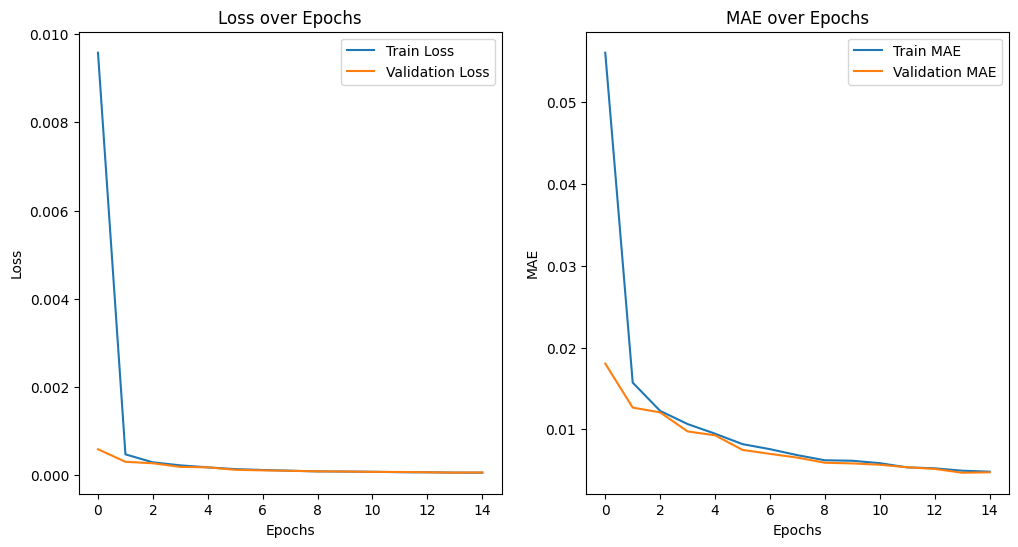

In [ ]:
import matplotlib.pyplot as plt

# 학습 성능 변화 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()
